### Imports

In [76]:
from contextlib import nullcontext

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.nn.functional import softmax
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Load Model
### Distil Roberta

Huggingface

In [77]:
MODEL = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [78]:
with open('sampleText.txt') as file:
    sequence = file.read()
tokens = tokenizer(sequence, padding=True, truncation=True, return_tensors="pt")

In [79]:
# Feed the tokens to the model
with torch.no_grad():
    outputs = model(**tokens)

In [80]:
# Convert logits to probabilities
probabilities = softmax(outputs.logits, dim=-1)

# Get the predicted class (index of the highest probability)
predicted_class = torch.argmax(probabilities, dim=-1).item()

# Map the predicted class to the corresponding label
label_mapping = model.config.id2label
predicted_label = label_mapping[predicted_class]

print(f"Probabilities: {probabilities}")
print(f"Predicted Class: {predicted_class}")
print(f"Predicted Label: {predicted_label}")

Probabilities: tensor([[5.0872e-04, 1.6343e-03, 9.9786e-01]])
Predicted Class: 2
Predicted Label: positive


## Do this for all the news articles

In [81]:
newspapers = pd.read_csv("BTC_newspapers.csv")
newspapers

,Unnamed: 0,title,date,link,text
0,0,Bitcoin Price (BTC) News: Inflation Softer Tha...,"04/10/2025, 12:45 PM, +0000 UTC",https://www.coindesk.com/markets/2025/04/09/u-...,Inflation in the U.S. actually declined at the...
1,1,Michael Saylor Signals Resumption Of Strategy'...,"04/14/2025, 09:35 AM, +0000 UTC",https://www.benzinga.com/25/04/44784106/michae...,Benzinga Rankings give you vital metrics on an...
2,2,Bitcoin rebounds after a rosy inflation report...,"03/12/2025, 07:00 AM, +0000 UTC",https://fortune.com/crypto/2025/03/12/bitcoin-...,© 2025 Fortune Media IP Limited. All Rights Re...
3,3,Crypto prices rally after Trump backs 'crypto ...,"03/02/2025, 08:00 AM, +0000 UTC",https://www.bbc.com/news/articles/cn0jgggd7r4o,US President Donald Trump has revealed the nam...
4,4,Price of bitcoin falls more than 10%,"12/20/2024, 08:00 AM, +0000 UTC",https://abcnews.go.com/Business/price-bitcoin-...,The drop erases some of the gains enjoyed sinc...
...,...,...,...,...,...
158,158,Cryptocurrency Market News: SEC Wants To Defin...,"03/25/2024, 07:00 AM, +0000 UTC",https://www.investopedia.com/cryptocurrency-ma...,Crypto News From Last Week and What To Expect ...
159,159,"Spot Bitcoin ETFs Are Approved by SEC, Cleared...","01/10/2024, 08:00 AM, +0000 UTC",https://www.investopedia.com/spot-bitcoin-etfs...,Thomas Trutschel / Contributor / Getty Images\...
160,160,The Fall of Terra: A Timeline of the Meteoric ...,"06/01/2022, 07:00 AM, +0000 UTC",https://www.coindesk.com/learn/the-fall-of-ter...,"The Terra network and its leader, Do Kwon, ros..."
161,161,MSTR Outshines Magnificent 7 With 133% 1-Year ...,"04/16/2025, 04:56 PM, +0000 UTC",https://cryptopotato.com/mstr-outshines-magnif...,Strategy’s Bitcoin playbook has seen it outper...


In [82]:
def preprocess(str):
    # Remove punctuation, whitespace, and special characters, standardize case
    pattern = r'[^\w\s]|[\n\r\t]'
    preprocessed = re.sub(pattern, '', str).upper()
    return preprocessed

In [83]:
def get_sentiment(str):
    tokens = tokenizer(preprocess(str), padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**tokens)
    probabilities = softmax(outputs.logits, dim=-1)
    predicted_class = torch.argmax(probabilities, dim=-1).item()
    label_mapping = model.config.id2label
    predicted_label = label_mapping[predicted_class]
    return predicted_label, probabilities.tolist()[0]

## Apply the sentiment function for the newspapers

In [101]:
newspapers['things'] = newspapers['text'].astype(str).apply(get_sentiment)
newspapers['sentiment'] = newspapers['things'].apply(lambda x: x[0])
newspapers['score'] = newspapers['things'].apply(lambda x: 100*(-1 * x[1][0] + 1 * x[1][2]))
newspapers.drop('things', axis=1, inplace=True)

In [102]:
newspapers['sentiment'].value_counts()

sentiment
neutral     157
negative      3
positive      3
Name: count, dtype: int64

In [103]:
newspapers[['title', 'score', 'sentiment']]

,title,score,sentiment
0,Bitcoin Price (BTC) News: Inflation Softer Tha...,0.008663,neutral
1,Michael Saylor Signals Resumption Of Strategy'...,0.002957,neutral
2,Bitcoin rebounds after a rosy inflation report...,-0.002954,neutral
3,Crypto prices rally after Trump backs 'crypto ...,0.009779,neutral
4,Price of bitcoin falls more than 10%,0.035854,neutral
...,...,...,...
158,Cryptocurrency Market News: SEC Wants To Defin...,0.002032,neutral
159,"Spot Bitcoin ETFs Are Approved by SEC, Cleared...",0.007088,neutral
160,The Fall of Terra: A Timeline of the Meteoric ...,-0.000022,neutral
161,MSTR Outshines Magnificent 7 With 133% 1-Year ...,0.011212,neutral


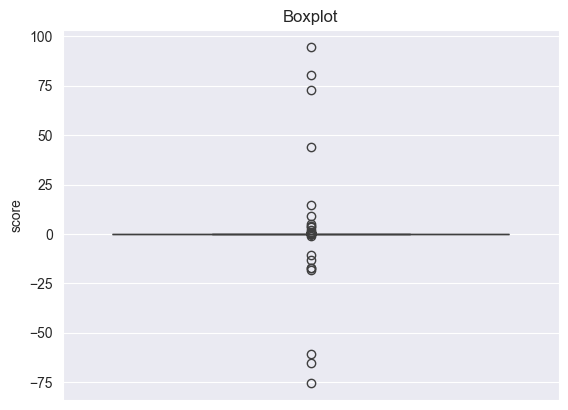

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=newspapers, y='score')

# Add title
plt.title("Boxplot")

# Show the plot
plt.show()

In [106]:
newspapers.to_csv('BTC_newspapers.csv')

In [107]:
def sentimentAnalysis(newspapers_df, NEGATIVE=-1, NEUTRAL=0, POSITIVE=1):
    newspapers_df['things'] = newspapers_df['text'].astype(str).apply(get_sentiment)
    newspapers_df['sentiment'] = newspapers_df['things'].apply(lambda x: x[0])
    newspapers_df['score'] = newspapers_df['things'].apply(lambda x: 100 * (NEGATIVE * x[1][0] + NEUTRAL * x[0][1] + POSITIVE * x[1][2]))
    newspapers_df.drop('things', axis=1, inplace=True)
    return newspapers_df